# Exploring Kerchunk with SST and UKCP datasets

Here, we use kerchunk files accessed through various routes:
 1. JASMIN Group Workspace
 2. Data copied to this VM
 
In both cases, the Kerchunk file references HTTP endpoints for its file access, and we assume it is only reading the chunks required.

In [1]:
import xarray as xr
import cartopy
import pandas
import matplotlib.pyplot as plt

import kerchunk_tools.xarray_wrapper as wrap_xr

In [2]:
index_uri = "https://gws-access.jasmin.ac.uk/public/cmip6_prep/eodh-eocis/esacci-sst-l4.json.zst"
ds = wrap_xr.wrap_xr_open(index_uri, compression="infer", scheme="http")

In [3]:
layer = ds.analysed_sst.sel(time="2020-01-01", lat=slice(30, 60), lon=slice(-10, 30)).squeeze()

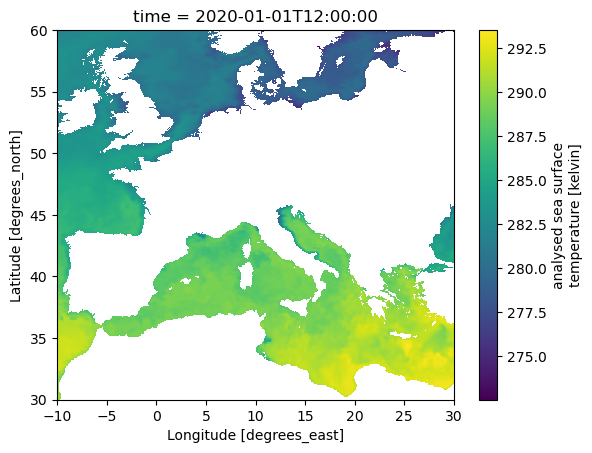

In [4]:
layer.plot()

## Read a UKCP kerchunk file (hosted on our EODH Cloud)

There were problems with authz when using the CEDA archive dap service (to be resolved another time). 

So, we:
 1. Copied some UKCP files to the EODH Cloud VM
 2. Indexed locally with Kerchunk
 3. Set up an Apache webserver to serve them
 4. Showed they work :-)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import fsspec

index_uri = "http://192.171.169.76/kerchunks/ukcp-5km-tasmax.json"
mapper = fsspec.get_mapper("reference://", fo=index_uri)
ds = xr.open_zarr(mapper, consolidated=False)

In [6]:
ds

<xarray.Dataset>
Dimensions:                       (ensemble_member: 1, time: 21600,
                                   projection_y_coordinate: 244,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * ensemble_member               (ensemble_member) float64 1.0
    ensemble_member_id            (time, ensemble_member) object dask.array<chunksize=(1, 1), meta=np.ndarray>
    latitude                      (time, projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(1, 244, 180), meta=np.ndarray>
    longitude                     (time, projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(1, 244, 180), meta=np.ndarray>
    month_number                  (time) float64 dask.array<chunksize=(3600,), meta=np.ndarray>
  * projection_x_coordinate       (projection_x_coordinate) float64 -1.975e+0...
  * projection_y_coordinate       (projection_y_coordinate) float64 -3.25e+04...
  * time                          (time) object 1980-12-01 12:00:00 ... 2080-...
    year                          (time) float64 dask.array<chunksize=(3600,), meta=np.ndarray>
    yyyymmdd                      (time) object dask.array<chunksize=(3600,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 dask.array<chunksize=(1, 244, 2), meta=np.ndarray>
    tasmax                        (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 3600, 244, 180), meta=np.ndarray>
    time_bnds                     (time, bnds) object dask.array<chunksize=(3600, 2), meta=np.ndarray>
    transverse_mercator           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/15)
    Conventions:     CF-1.7
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2021-06-09T16:58:11
    domain:          uk
    frequency:       day
    ...              ...
    references:      https://ukclimateprojections.metoffice.gov.uk
    resolution:      5km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - Regridded 2.2km convection-per...
    version:         v20210615

In [7]:
x = ds.tasmax.sel(time=slice("1980-12-01 12", "1980-12-03 12"))
x.time

<xarray.DataArray 'time' (time: 3)>
array([cftime.Datetime360Day(1980, 12, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 12, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1980, 12, 3, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    month_number  (time) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time          (time) object 1980-12-01 12:00:00 ... 1980-12-03 12:00:00
    year          (time) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    yyyymmdd      (time) object dask.array<chunksize=(3,), meta=np.ndarray>
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time

In [8]:
float(x.max())

11.403680801391602

In [9]:
layer = x.sel(time="1980-12-01 12", projection_y_coordinate=slice(-12000, 1000000), 
                      projection_x_coordinate=slice(-1000, 627500.)).squeeze()

In [10]:
float(layer.max())

11.213251113891602

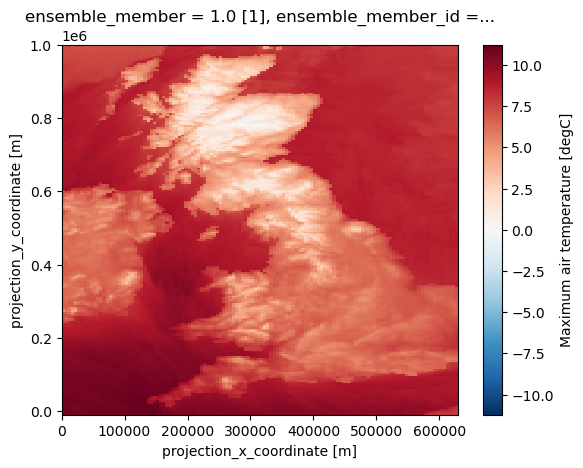

In [11]:
layer.plot()

In [12]:
# This takes almost no time - so it must be reading only 1 chunk from a NetCDF file
float(ds.tasmax.isel(time=2000, projection_x_coordinate=170, projection_y_coordinate=160).max())

12.373285293579102

## Let's read some CMIP5 data

In [13]:
index_uri = "http://192.171.169.76/kerchunks/cmip5-rcp85-tasmax.json"
mapper = fsspec.get_mapper("reference://", fo=index_uri) 
ds = xr.open_zarr(mapper, consolidated=False)

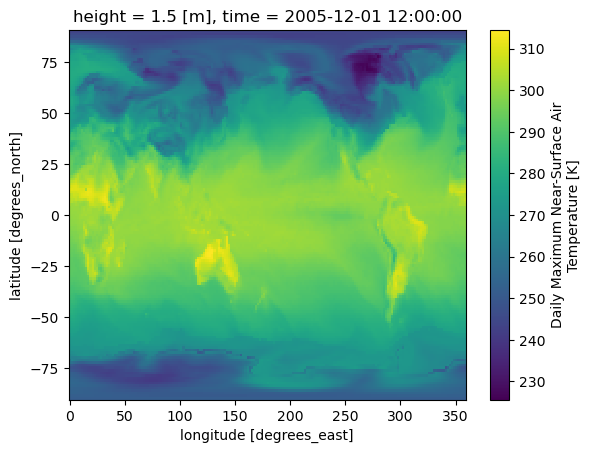

In [14]:
ds.tasmax.sel(time="2005-12-01").plot()

## Note on how the kerchunking worked

```
# Scan local file paths
kerchunk_tools create -e netcdf3 -p /data0/kerchunks -o cmip5-rcp85-tasmax.json -b 50000 /data0/archive/cmip5/*.nc

# Change local paths to http paths in the kerchunk file
perl -p -i -w -e 's|/data0|http://192.171.169.76|g' /data0/kerchunks/cmip5-rcp85-tasmax.json

```